## Dataset Loading and Basic Inspection



I will use the Amazon-Photo dataset from the PyTorch Geometric library.  This is a homogeneous graph where each node represents a product in the “Photo” category on Amazon.  An edge appears between two products when they are often viewed or purchased together.

In [1]:
import torch
from torch_geometric.datasets import Amazon

dataset = Amazon(root="data/Amazon", name="Photo")
data = dataset[0]

print(data)
print("Num nodes:", data.num_nodes)
print("Num edges:", data.num_edges)
print("Node feature dimension:", data.num_node_features)
print("Num classes:", dataset.num_classes)


Data(x=[7650, 745], edge_index=[2, 238162], y=[7650])
Num nodes: 7650
Num edges: 238162
Node feature dimension: 745
Num classes: 8


Graph contains:
- Nodes: Each node is a product.  
- Edges: Directed, co-view or co-purchase links.  
- Node features: A 745-dimensional bag-of-words vector describing each product (e.g., title or text metadata).  
- Labels: Each node has a class label representing the product’s category. The dataset has 8 classes


Lets remove all external node features because the goal is to ensure the GNN learns only from graph structure, not from textual or semantic information provided by the dataset.  


In [2]:
original_features = data.x.clone()
original_feature_dim = data.x.shape[1]
data.x = None

Lets now create a fixed train (70%), validation (15%), and test (15%) split.  The split is stratified so each set has a similar class distribution. This avoids problems where a class ends up missing from one of the sets.  


In [3]:
from sklearn.model_selection import train_test_split

labels = data.y.numpy()

# First split: train vs (val+test)
train_idx, temp_idx = train_test_split(
    torch.arange(data.num_nodes),
    test_size=0.3,
    stratify=labels,
    random_state=42
)

# Second split: val vs test
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=labels[temp_idx],
    random_state=42
)

# Initialize masks
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

print(f"  Train nodes: {int(data.train_mask.sum())}")
print(f"  Val nodes:   {int(data.val_mask.sum())}")
print(f"  Test nodes:  {int(data.test_mask.sum())}")


  Train nodes: 5355
  Val nodes:   1147
  Test nodes:  1148


c:\Users\aaliu\anaconda3\Lib\site-packages\torch_geometric\data\data.py:187: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'y'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  return sum([v.num_nodes for v in self.node_stores])
c:\Users\aaliu\anaconda3\Lib\site-packages\torch_geometric\data\data.py:187: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'y'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  return sum([v.num_nodes for v in self.node_stores])
c:\Users\aaliu\anaconda3\Lib\site-packages\torch_geometric\data\data.py:187: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'y', 'train_mask'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  return sum([v.num_nodes for v in self.node_stores])
c:\Users\aaliu\anaconda3\Lib\site-packages\t

Lets now see the class distribution. Before training anything, it's useful to check how the labels are spread across the dataset.  
This gives a quick sense of whether the classes are balanced or if some are much more common than others so we can handle class imbalance probelms. 



Overall class distribution (8 classes):
  Class 0:   369 nodes (  4.8%)
  Class 1:  1686 nodes ( 22.0%)
  Class 2:   703 nodes (  9.2%)
  Class 3:   915 nodes ( 12.0%)
  Class 4:   882 nodes ( 11.5%)
  Class 5:   823 nodes ( 10.8%)
  Class 6:  1941 nodes ( 25.4%)
  Class 7:   331 nodes (  4.3%)


c:\Users\aaliu\anaconda3\Lib\site-packages\torch_geometric\data\data.py:187: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'test_mask', 'train_mask', 'edge_index', 'val_mask'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  return sum([v.num_nodes for v in self.node_stores])


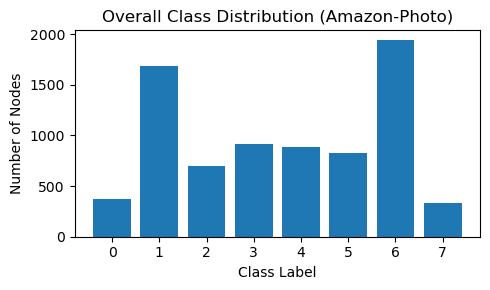

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

# Overall class distribution

class_counts = Counter(data.y.numpy())
num_classes = len(class_counts)

print(f"\nOverall class distribution ({num_classes} classes):")
for class_id in sorted(class_counts.keys()):
    count = class_counts[class_id]
    percentage = (count / data.num_nodes) * 100
    print(f"  Class {class_id}: {count:5d} nodes ({percentage:5.1f}%)")


# Simple bar plot
plt.figure(figsize=(5,3))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Label")
plt.ylabel("Number of Nodes")
plt.title("Overall Class Distribution (Amazon-Photo)")
plt.tight_layout()
plt.show()


In [5]:
# Distribution per split
for split_name, mask in [('Train', data.train_mask), 
                         ('Val', data.val_mask), 
                         ('Test', data.test_mask)]:
    split_labels = data.y[mask]
    split_counts = Counter(split_labels.numpy())
    print(f"\n{split_name} set distribution:")
    for class_id in sorted(split_counts.keys()):
        count = split_counts[class_id]
        percentage = (count / mask.sum().item()) * 100
        print(f"  Class {class_id}: {count:4d} ({percentage:4.1f}%)")




Train set distribution:
  Class 0:  258 ( 4.8%)
  Class 1: 1180 (22.0%)
  Class 2:  492 ( 9.2%)
  Class 3:  641 (12.0%)
  Class 4:  617 (11.5%)
  Class 5:  576 (10.8%)
  Class 6: 1359 (25.4%)
  Class 7:  232 ( 4.3%)

Val set distribution:
  Class 0:   56 ( 4.9%)
  Class 1:  253 (22.1%)
  Class 2:  105 ( 9.2%)
  Class 3:  137 (11.9%)
  Class 4:  132 (11.5%)
  Class 5:  123 (10.7%)
  Class 6:  291 (25.4%)
  Class 7:   50 ( 4.4%)

Test set distribution:
  Class 0:   55 ( 4.8%)
  Class 1:  253 (22.0%)
  Class 2:  106 ( 9.2%)
  Class 3:  137 (11.9%)
  Class 4:  133 (11.6%)
  Class 5:  124 (10.8%)
  Class 6:  291 (25.3%)
  Class 7:   49 ( 4.3%)


The dataset has eight classes and the distribution is unbalanced, with two classes (1,6) taking up almost half of the nodes.  
The stratified split kept the proportions stable across train, validation, and test sets. Each split mirrors the original percentages, so nothing looks skewed or missing. This gives a clean baseline to work with when training a model later.

We will use accuracy as evaluation metric. Accuracy works well as a first evaluation metric since all classes appear in each split and none of them is extremely rare.  It's a simple way to see if the model is learning the categories at all before trying anything more advanced. F1 could be added later if I want to look more closely at how the model behaves on the smaller classes, but it's not essential here.
For node classification, cross entropy is the usual loss because the labels are discrete and each node belongs to exactly one class.  


Lets see also degree distribution

In [6]:

deg = torch.bincount(data.edge_index[0], minlength=data.num_nodes)


print(f"  Min degree:      {deg.min().item()}")
print(f"  Max degree:      {deg.max().item()}")
print(f"  Mean degree:     {deg.float().mean().item():.2f}")
print(f"  Median degree:   {deg.median().item()}")
print(f"  Std deviation:   {deg.float().std().item():.2f}")



  Min degree:      0
  Max degree:      1434
  Mean degree:     31.13
  Median degree:   22
  Std deviation:   47.28


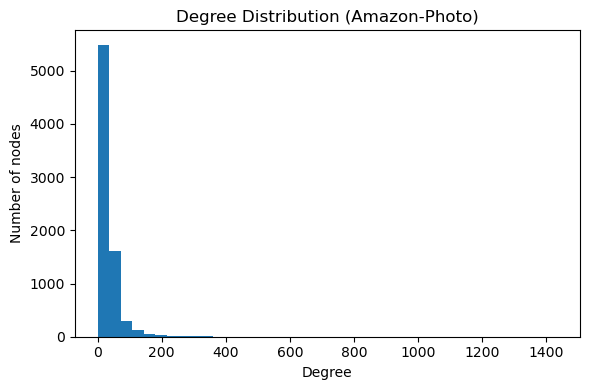

In [7]:
# Histogram
plt.figure(figsize=(6,4))
plt.hist(deg.numpy(), bins=40)
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree Distribution (Amazon-Photo)")
plt.tight_layout()
plt.show()


The degree histogram gives a quick sense of how connections are spread across the graph.  
Most products have only a small number of co-view links, while a smaller group of items acts as hubs with many connections.  The statistics show a wide gap between the minimum and maximum degrees, which is typical for real product graphs.  This variation in connectivity provides useful structural signals for models trained on the graph.


In summary: In the Amazon-Photo graph from PyTorch Geometric, each node represents a product in the photo category on Amazon, and edges show which products tend to be viewed or purchased together.  The graph is homogeneous, so all nodes share the same type and all edges carry the same meaning. This makes the setup straightforward for node classification. The graph has 7,650 nodes and 238,162 stored edges.  
Since the graph is undirected and stored as directed pairs, this corresponds to roughly half as many unique connections.   There are eight product categories, which serve as the class labels. Node degrees range from 0 to 1,434, with a mean of about 31 and a median of 22.  Most nodes sit in the lower range, while a small number of hubs connect to many others. The class distribution is uneven but stable across the train, validation, and test splits due to stratified sampling.  These properties make the dataset suitable for testing how well a GNN can learn from graph structure alone.


## Node feature augmentation

Lets now compare different ways of constructing node features for a graph. I keep the same graph and the same train/validation/test split, and I always train the same GCN architecture. Only the input node features change between experiments. The goal is to see how different feature designs (one hot, constant, random, structural, spectral, centrality based) affect the final performance.


### One-Hot Encoding

Lets create one-hot node features. It typically performs best in the transductive setting as it provides unique identifiers for each node, allowing the GCN to learn node-specific patterns. But it can fail inductive setting as it can't be generalize to new nodes. To acheive this we will use identity matrix and use its rows as one-hot node features. 

In [52]:
import torch
import torch.nn.functional as F

# Number of nodes
num_nodes = data.num_nodes

# One-hot features
one_hot_features = torch.eye(num_nodes)

print("One-hot feature shape:", one_hot_features.shape)

# Attach to data.x
data.x = one_hot_features

# Sanity check
print("Node 0 feature (first 10 dims):", data.x[0, :10])
print("Node 1 feature (first 10 dims):", data.x[1, :10])


One-hot feature shape: torch.Size([7650, 7650])
Node 0 feature (first 10 dims): tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Node 1 feature (first 10 dims): tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


Lets now build a three-layer GCN model. The flow is: input layer-> hidden1 -> hidden2 -> output.

In [53]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

in_dim = data.x.shape[1]        # one-hot feature dim = num_nodes
hidden_dim = 128                # neurons in first hidden layer
hidden_dim2 = 128               # neurons in second hidden layer
out_dim = dataset.num_classes

class GCNOneHot3Layer(torch.nn.Module):
    def __init__(self, in_dim, h1, h2, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, h1)  # 7650 nodes-> 128
        self.conv2 = GCNConv(h1, h2)      # 128 -> 128
        self.conv3 = GCNConv(h2, out_dim) # 128 -> 8 classes
        self.dropout_p = 0.5              # Randomly unplugs 50% of the neurons. It prevents the model from memorizing easy shortcuts.

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Layer 1 
        x = self.conv1(x, edge_index) # Message passing 1: taking to neighbours
        x = F.relu(x)                 # Activation, a mathematical filter that turns negative numbers into zeros. It helps the model handle complex, non-linear patterns.
        x = F.dropout(x, p=self.dropout_p, training=self.training) #Regularization

        # Layer 2
        x = self.conv2(x, edge_index) # Message passing 2: taking to 2-hop neighbours (neighbors of neighbors)
        x = F.relu(x)                 # Activation
        x = F.dropout(x, p=self.dropout_p, training=self.training) #Regularization

        # Layer 3 (output logits)
        x = self.conv3(x, edge_index) # Message passing 3 (3-hop reach) to produce final logits. No ReLU or Dropout on the final layer because we want the raw scores (logits) for the final prediction.

        return x

# Instantiate model
model = GCNOneHot3Layer(in_dim, hidden_dim, hidden_dim2, out_dim)

# Quick forward check
with torch.no_grad():
    logits = model(data)

print("Logits shape:", logits.shape)


Logits shape: torch.Size([7650, 8])


Lets create a training setup now. We use Adam optimizer with a small learning rate. 

In [55]:
import torch.optim as optim
import torch.nn as nn
# Define the Optimizer (The Teacher). Adam is adaptive and generally works well for GNNs
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  #The learning rate 0.01 determines the step size of the weight updates. wight_decay adds L2 regularization to prevent overfitting by penalizing large weights.

# Define the Loss Function (The Scoreboard). CrossEntropyLoss combines Softmax and NLLLoss, ideal for classification
loss_fn = nn.CrossEntropyLoss()

# Define Accuracy Helper (The Referee)
def accuracy(logits, labels):
    # argmax(dim=1) finds the index of the highest score (the predicted class)
    preds = logits.argmax(dim=1)
    # Check where prediction matches label, convert to float, and take the mean
    return (preds == labels).float().mean().item()

# Masks
train_mask = data.train_mask  # Training nodes
val_mask = data.val_mask      # Validation nodes


y = data.y # True labels for all nodes


Lets build a training loop. One epoch mean that the model sees the whole graph once, computes forward, loss, and updates all weights. We will repeat this 200 times so the model can adjust weights gradually. To plot loss and accuracy curves, we store the loss and accuracy values after every epoch.  

In [56]:
num_epochs = 200

# Tracking lists for plotting
loss_history = []
train_history = []
val_history = []
test_history = []

best_val_acc = 0
best_epoch = 0
best_state = None

for epoch in range(num_epochs):
    model.train()               # Set model to training mode
    optimizer.zero_grad()       # Clear previous gradients/updates

    logits = model(data)             # [N_nodes, num_classes]
    loss = loss_fn(logits[train_mask], y[train_mask]) # Compute loss only on training nodes

    loss.backward()     # Backpropagation: compute gradients. It traces the error backward through the network.It calculates how much every single neuron contributed to the mistake.
    optimizer.step()    # The Optimizer adjusts the weights of the neurons based on the backward pass.

    # Evaluate on train, val, and test
    model.eval()
    with torch.no_grad():
        train_acc = accuracy(logits[train_mask], y[train_mask])
        val_acc = accuracy(logits[val_mask], y[val_mask])
        test_acc = accuracy(logits[data.test_mask], y[data.test_mask])

    # Save metrics
    loss_history.append(loss.item())
    train_history.append(train_acc)
    val_history.append(val_acc)
    test_history.append(test_acc)

    # Track best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        best_state = model.state_dict()

    # Print progress every 20 epochs
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: loss={loss.item():.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")

print("Best epoch:", best_epoch)

Epoch 20: loss=0.9153, train_acc=0.7780, val_acc=0.7663, test_acc=0.7700
Epoch 40: loss=0.3348, train_acc=0.9204, val_acc=0.9041, test_acc=0.8990
Epoch 60: loss=0.2527, train_acc=0.9373, val_acc=0.9102, test_acc=0.9068
Epoch 80: loss=0.2339, train_acc=0.9430, val_acc=0.9207, test_acc=0.9138
Epoch 100: loss=0.2108, train_acc=0.9451, val_acc=0.9189, test_acc=0.9138
Epoch 120: loss=0.2057, train_acc=0.9503, val_acc=0.9259, test_acc=0.9181
Epoch 140: loss=0.2006, train_acc=0.9498, val_acc=0.9163, test_acc=0.9172
Epoch 160: loss=0.1920, train_acc=0.9500, val_acc=0.9224, test_acc=0.9260
Epoch 180: loss=0.1944, train_acc=0.9473, val_acc=0.9154, test_acc=0.9251
Epoch 200: loss=0.1868, train_acc=0.9539, val_acc=0.9215, test_acc=0.9268
Best epoch: 181


In [12]:
best_train_acc = train_history[best_epoch]
best_val_acc = val_history[best_epoch]
best_test_acc = test_history[best_epoch]

print("Train Acc at best epoch:", best_train_acc)
print("Val Acc at best epoch:", best_val_acc)
print("Test Acc at best epoch:", best_test_acc)

Train Acc at best epoch: 0.9477124214172363
Val Acc at best epoch: 0.9311246871948242
Test Acc at best epoch: 0.9216027855873108


Plotting Loss and Accuracy Curves

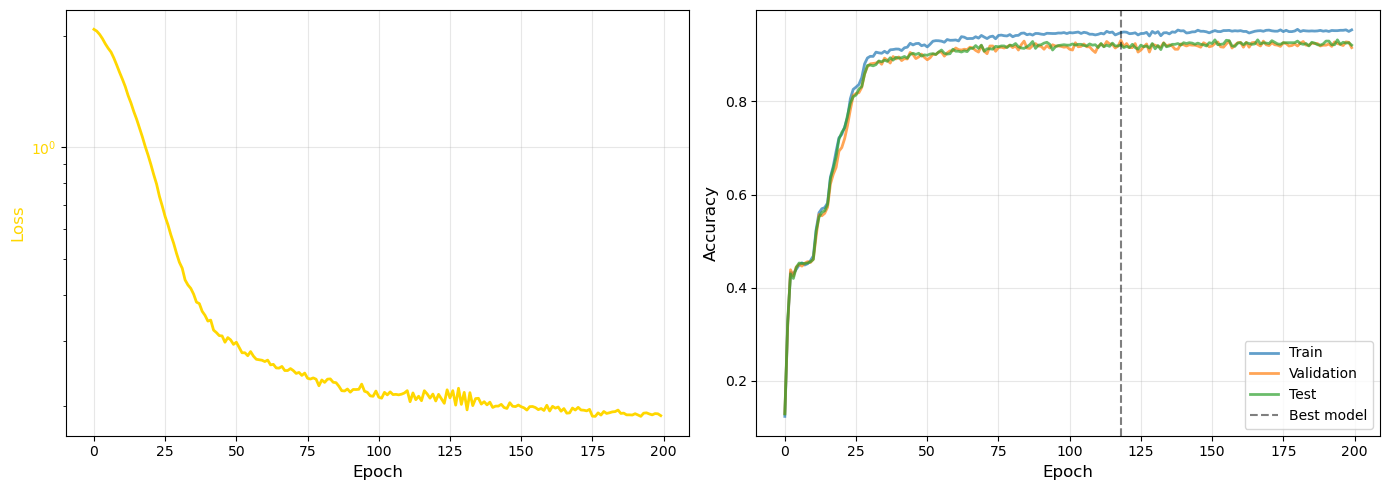

In [13]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
ax1.plot(loss_history, color="gold", linewidth=2)
ax1.set_yscale("log")
ax1.set_ylabel("Loss", color="gold", fontsize=12)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.tick_params(axis='y', labelcolor='gold')
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_history, label="Train", linewidth=2, alpha=0.7)
ax2.plot(val_history, label="Validation", linewidth=2, alpha=0.7)
ax2.plot(test_history, label="Test", linewidth=2, alpha=0.7)

# Best epoch marker
ax2.axvline(best_epoch, color='k', linestyle='--', label='Best model', alpha=0.5)

ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Observations:  
- Performance: 92%
-  High dimensional (7650 dims)
- Can memorize node-specific patterns
- Limitation: Cannot generalize to new products (inductive fails)


### Constant Features

Now we will use constant features. Every node gets the exact same input vector. The model is forced to rely only on the graph structure instead of node-specific content. This is inductive, because the feature is not tied to node IDs. New nodes can be handled easily because they also get the same constant vector.

In [43]:
# Constant feature dimension 
const_dim = 4

# Every node gets the same vector of ones
constant_features = torch.ones((data.num_nodes, const_dim))

# Attach to data
data.x = constant_features

print("Constant feature shape:", data.x.shape)
print("Sample feature:", data.x[0])


Constant feature shape: torch.Size([7650, 4])
Sample feature: tensor([1., 1., 1., 1.])


In [44]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Model for constant features
in_dim = data.x.shape[1]  # 4 dimensions
hidden_dim = 128
hidden_dim2 = 128
out_dim = dataset.num_classes

class GCNConstant3Layer(torch.nn.Module):
    def __init__(self, in_dim, h1, h2, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, h1)   # 4 -> 128
        self.conv2 = GCNConv(h1, h2)       # 128 -> 128
        self.conv3 = GCNConv(h2, out_dim)  # 128 -> 8 classes
        self.dropout_p = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Layer 1: Message passing with constant input
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        # Layer 2: Continue aggregating structural information
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        # Layer 3: Final classification layer
        x = self.conv3(x, edge_index)
        return x

model_const = GCNConstant3Layer(in_dim, hidden_dim, hidden_dim2, out_dim).to(data.edge_index.device)

import torch.optim as optim
import torch.nn as nn

# Training setup - same as before
optimizer = optim.Adam(model_const.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

# Training loop
num_epochs = 200

loss_history_const = []
train_history_const = []
val_history_const = []
test_history_const = []

best_val_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    model_const.train()
    optimizer.zero_grad()

    logits = model_const(data)
    loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    # Evaluate
    model_const.eval()
    with torch.no_grad():
        # Assuming 'accuracy' function is defined earlier in your notebook
        train_acc = accuracy(logits[data.train_mask], data.y[data.train_mask])
        val_acc = accuracy(logits[data.val_mask], data.y[data.val_mask])
        test_acc = accuracy(logits[data.test_mask], data.y[data.test_mask])

    loss_history_const.append(loss.item())
    train_history_const.append(train_acc)
    val_history_const.append(val_acc)
    test_history_const.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: loss={loss.item():.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")

print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Final test accuracy: {test_history_const[best_epoch]:.4f}")

Epoch 20: loss=1.9418, train_acc=0.2706, val_acc=0.2677, test_acc=0.2674
Epoch 40: loss=1.9135, train_acc=0.2926, val_acc=0.2851, test_acc=0.3049
Epoch 60: loss=1.7794, train_acc=0.3382, val_acc=0.3208, test_acc=0.3275
Epoch 80: loss=1.6783, train_acc=0.3841, val_acc=0.3888, test_acc=0.3876
Epoch 100: loss=1.6430, train_acc=0.3901, val_acc=0.3906, test_acc=0.3885
Epoch 120: loss=1.6194, train_acc=0.3808, val_acc=0.3819, test_acc=0.3789
Epoch 140: loss=1.5935, train_acc=0.3823, val_acc=0.3810, test_acc=0.3789
Epoch 160: loss=1.5760, train_acc=0.3888, val_acc=0.3976, test_acc=0.3955
Epoch 180: loss=1.5399, train_acc=0.3994, val_acc=0.3862, test_acc=0.3807
Epoch 200: loss=1.5652, train_acc=0.4021, val_acc=0.4002, test_acc=0.3972

Best validation accuracy: 0.4211 at epoch 189
Final test accuracy: 0.4016


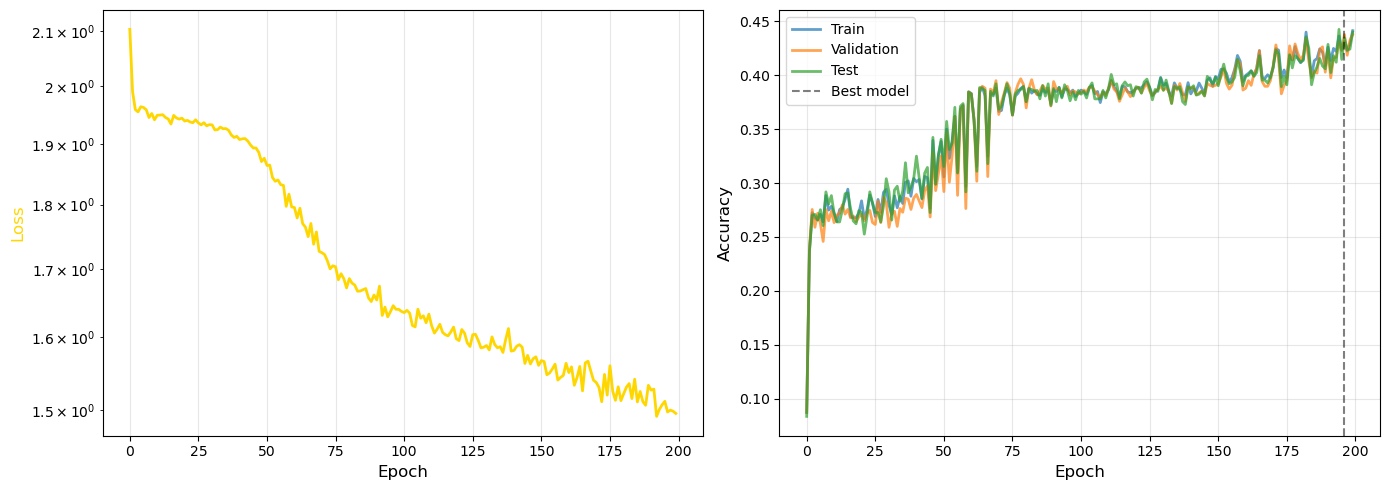

In [17]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
ax1.plot(loss_history, color="gold", linewidth=2)
ax1.set_yscale("log")
ax1.set_ylabel("Loss", color="gold", fontsize=12)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.tick_params(axis='y', labelcolor='gold')
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_history, label="Train", linewidth=2, alpha=0.7)
ax2.plot(val_history, label="Validation", linewidth=2, alpha=0.7)
ax2.plot(test_history, label="Test", linewidth=2, alpha=0.7)

# Best epoch marker
ax2.axvline(best_epoch, color='k', linestyle='--', label='Best model', alpha=0.5)

ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Observations:  
- Performance: 40% 
- Minimal dimension (4 dims)
- Constant features provide no node-specific information  
- The model learns purely from graph structure through message passing  
- This serves as a baseline showing how much can be learned from topology alone  

### Random Features (Transductive)

Now we use random features that are fixed throughout training. Each node gets a random vector that never changes. These features are "transductive" because they are specific to the nodes in our current graph and cannot be transferred to new unseen nodes.To do this we generate random numbers once before training starts and freeze them. Random features can be surprisingly effective. They act like random hash functions that break symmetries between nodes. Even though the values are random, they give each node a unique signature that helps the GNN learn structural patterns.

In [18]:
# Random features (Transductive) - fixed for all epochs
torch.manual_seed(42)  # For reproducibility

random_dim = 128
random_trans_features = torch.randn(data.num_nodes, random_dim)

# Normalize to unit length for stability
random_trans_features = F.normalize(random_trans_features, p=2, dim=1)

# Attach to data (handle device)
data.x = random_trans_features.to(data.edge_index.device)

print("Random (Transductive) feature shape:", data.x.shape)
print("Sample feature (node 0, first 10 dims):", data.x[0, :10])


Random (Transductive) feature shape: torch.Size([7650, 128])
Sample feature (node 0, first 10 dims): tensor([ 0.1772,  0.1367,  0.0828, -0.1936,  0.0624, -0.1135, -0.0040, -0.1475,
        -0.0691,  0.1516])


In [19]:
# Model for random transductive features
in_dim = data.x.shape[1]  # 128 dimensions
hidden_dim = 128
hidden_dim2 = 128
out_dim = dataset.num_classes

class GCNRandomTrans3Layer(torch.nn.Module):
    def __init__(self, in_dim, h1, h2, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, h1)
        self.conv2 = GCNConv(h1, h2)
        self.conv3 = GCNConv(h2, out_dim)
        self.dropout_p = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = self.conv3(x, edge_index)
        return x

model_rand_trans = GCNRandomTrans3Layer(in_dim, hidden_dim, hidden_dim2, out_dim).to(data.edge_index.device)

# Training
optimizer = optim.Adam(model_rand_trans.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 200

loss_history_rand_trans = []
train_history_rand_trans = []
val_history_rand_trans = []
test_history_rand_trans = []

best_val_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    model_rand_trans.train()
    optimizer.zero_grad()

    logits = model_rand_trans(data)
    loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    model_rand_trans.eval()
    with torch.no_grad():
        train_acc = accuracy(logits[data.train_mask], data.y[data.train_mask])
        val_acc = accuracy(logits[data.val_mask], data.y[data.val_mask])
        test_acc = accuracy(logits[data.test_mask], data.y[data.test_mask])

    loss_history_rand_trans.append(loss.item())
    train_history_rand_trans.append(train_acc)
    val_history_rand_trans.append(val_acc)
    test_history_rand_trans.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: loss={loss.item():.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")

print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Final test accuracy: {test_history_rand_trans[best_epoch]:.4f}")

Epoch 20: loss=1.5969, train_acc=0.4390, val_acc=0.4324, test_acc=0.4364
Epoch 40: loss=0.8710, train_acc=0.7802, val_acc=0.7724, test_acc=0.7648
Epoch 60: loss=0.5585, train_acc=0.8450, val_acc=0.8221, test_acc=0.8328
Epoch 80: loss=0.4601, train_acc=0.8661, val_acc=0.8500, test_acc=0.8458
Epoch 100: loss=0.4140, train_acc=0.8822, val_acc=0.8692, test_acc=0.8685
Epoch 120: loss=0.3766, train_acc=0.8995, val_acc=0.8788, test_acc=0.8702
Epoch 140: loss=0.3549, train_acc=0.8993, val_acc=0.8779, test_acc=0.8737
Epoch 160: loss=0.3485, train_acc=0.9040, val_acc=0.8875, test_acc=0.8737
Epoch 180: loss=0.3332, train_acc=0.9107, val_acc=0.8788, test_acc=0.8824
Epoch 200: loss=0.3420, train_acc=0.9092, val_acc=0.8832, test_acc=0.8833

Best validation accuracy: 0.8910 at epoch 174
Final test accuracy: 0.8798


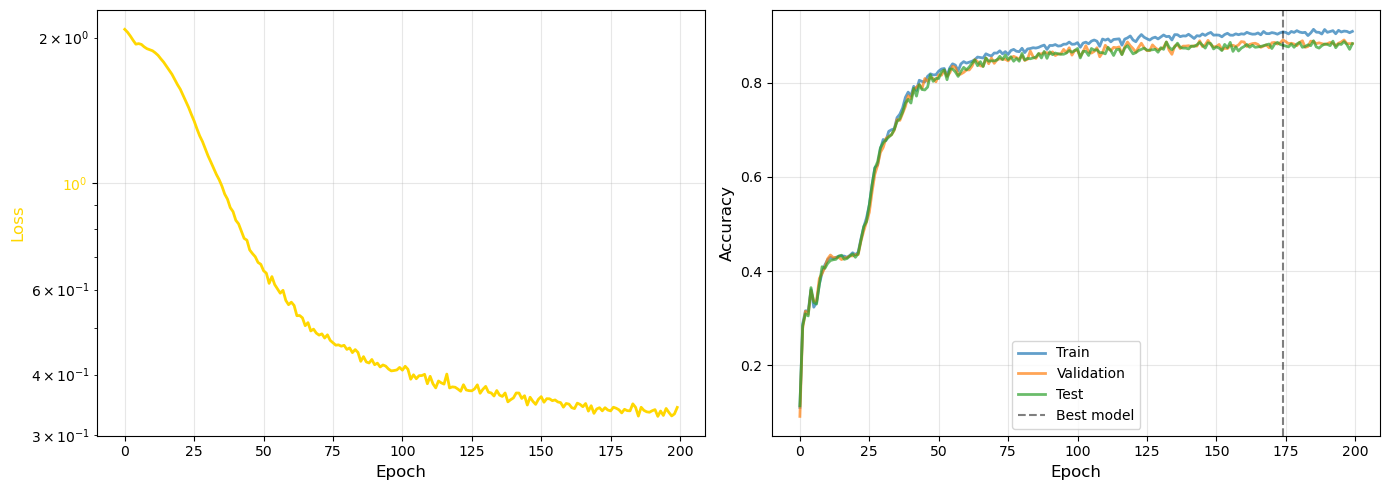

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve for random features
ax1.plot(loss_history_rand_trans, color="gold", linewidth=2)
ax1.set_yscale("log")
ax1.set_ylabel("Loss", color="gold", fontsize=12)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.tick_params(axis='y', labelcolor='gold')
ax1.grid(True, alpha=0.3)

# Accuracy plot for random features
ax2.plot(train_history_rand_trans, label="Train", linewidth=2, alpha=0.7)
ax2.plot(val_history_rand_trans, label="Validation", linewidth=2, alpha=0.7)
ax2.plot(test_history_rand_trans, label="Test", linewidth=2, alpha=0.7)

# Best epoch marker
ax2.axvline(best_epoch, color='k', linestyle='--', label='Best model', alpha=0.5)

ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Observations:  
- Performance: 88.5%  
- Medium dimension (128 dims)
- Acts as position encoding
- Fixed random features act as implicit regularization  
- They break symmetries i-e nodes with similar structure get different random signatures  
- Surprisingly effective despite being completely random  

### Random Features (Inductive)

Now we test random features that change every epoch. This simulates the inductive setting where we cannot rely on fixed node features. Each epoch, nodes get completely new random features.This is much harder for the model because it cannot learn patterns in the features themselves. It only learns how graph structure aggregates information through message passing.

In [21]:
# Helper function to generate new random features
def generate_random_features(num_nodes, feature_dim=128):
    features = torch.randn(num_nodes, feature_dim)
    features = F.normalize(features, p=2, dim=1)
    return features

# Initialize 
random_dim = 128
data.x = generate_random_features(data.num_nodes, random_dim).to(data.edge_index.device)

print("Random (Inductive) feature shape:", data.x.shape)

Random (Inductive) feature shape: torch.Size([7650, 128])


In [22]:
# Model for random inductive features
in_dim = data.x.shape[1]  # 128 dimensions
hidden_dim = 128
hidden_dim2 = 128
out_dim = dataset.num_classes

class GCNRandomInd3Layer(torch.nn.Module):
    def __init__(self, in_dim, h1, h2, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, h1)
        self.conv2 = GCNConv(h1, h2)
        self.conv3 = GCNConv(h2, out_dim)
        self.dropout_p = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = self.conv3(x, edge_index)
        return x

model_rand_ind = GCNRandomInd3Layer(in_dim, hidden_dim, hidden_dim2, out_dim).to(data.edge_index.device)

# Training with feature regeneration each epoch
optimizer = optim.Adam(model_rand_ind.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 200

loss_history_rand_ind = []
train_history_rand_ind = []
val_history_rand_ind = []
test_history_rand_ind = []

best_val_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    data.x = generate_random_features(data.num_nodes, random_dim).to(data.edge_index.device)
    
    model_rand_ind.train()
    optimizer.zero_grad()

    logits = model_rand_ind(data)
    loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    model_rand_ind.eval()
    with torch.no_grad():
        train_acc = accuracy(logits[data.train_mask], data.y[data.train_mask])
        val_acc = accuracy(logits[data.val_mask], data.y[data.val_mask])
        test_acc = accuracy(logits[data.test_mask], data.y[data.test_mask])

    loss_history_rand_ind.append(loss.item())
    train_history_rand_ind.append(train_acc)
    val_history_rand_ind.append(val_acc)
    test_history_rand_ind.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: loss={loss.item():.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")

print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Final test accuracy: {test_history_rand_ind[best_epoch]:.4f}")

Epoch 20: loss=1.9431, train_acc=0.2585, val_acc=0.2607, test_acc=0.2500
Epoch 40: loss=1.9200, train_acc=0.2691, val_acc=0.2563, test_acc=0.2779
Epoch 60: loss=1.8663, train_acc=0.3283, val_acc=0.3208, test_acc=0.3249
Epoch 80: loss=1.8069, train_acc=0.3455, val_acc=0.3470, test_acc=0.3484
Epoch 100: loss=1.7752, train_acc=0.3591, val_acc=0.3618, test_acc=0.3519
Epoch 120: loss=1.7455, train_acc=0.3608, val_acc=0.3627, test_acc=0.3641
Epoch 140: loss=1.7255, train_acc=0.3683, val_acc=0.3714, test_acc=0.3641
Epoch 160: loss=1.7103, train_acc=0.3690, val_acc=0.3749, test_acc=0.3650
Epoch 180: loss=1.7173, train_acc=0.3684, val_acc=0.3740, test_acc=0.3667
Epoch 200: loss=1.7394, train_acc=0.3669, val_acc=0.3723, test_acc=0.3711

Best validation accuracy: 0.3810 at epoch 153
Final test accuracy: 0.3711


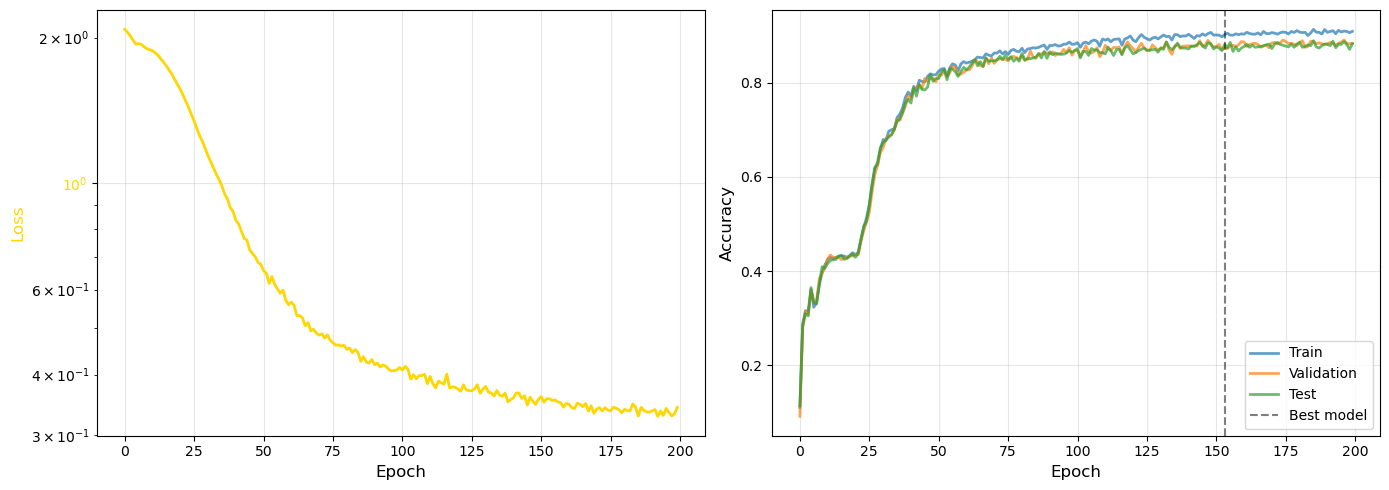

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve for random features
ax1.plot(loss_history_rand_trans, color="gold", linewidth=2)
ax1.set_yscale("log")
ax1.set_ylabel("Loss", color="gold", fontsize=12)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.tick_params(axis='y', labelcolor='gold')
ax1.grid(True, alpha=0.3)

# Accuracy plot for random features
ax2.plot(train_history_rand_trans, label="Train", linewidth=2, alpha=0.7)
ax2.plot(val_history_rand_trans, label="Validation", linewidth=2, alpha=0.7)
ax2.plot(test_history_rand_trans, label="Test", linewidth=2, alpha=0.7)

# Best epoch marker
ax2.axvline(best_epoch, color='k', linestyle='--', label='Best model', alpha=0.5)

ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Observations:  
- Performance: 38%  
- Changing features each epoch makes learning unstable  
- Model cannot memorize node-specific patterns  
- Performs worse than transductive random features  
- Forces pure reliance on graph structure aggregation  

### Node Degree Features

Now we use node degree as a feature. The degree is simply how many connections each node has. In a co-purchase network, highly connected products (hubs) might belong to different categories than isolated products.

We use both raw degree and log-transformed degree to handle the wide range of connectivity (from 0 to 1434 in our graph).

In [24]:
from torch_geometric.utils import degree

# Compute degree for each node
node_degrees = degree(data.edge_index[0], num_nodes=data.num_nodes, dtype=torch.float)

# Create feature matrix: [raw_degree, log_degree]
degree_features = torch.zeros(data.num_nodes, 2)
degree_features[:, 0] = node_degrees              # Raw degree
degree_features[:, 1] = torch.log(node_degrees + 1)  # Log degree (add 1 to handle degree 0)

# Normalize features for stable training
degree_features = (degree_features - degree_features.mean(dim=0)) / (degree_features.std(dim=0) + 1e-8)

# Assign to data and move to correct device
data.x = degree_features.to(data.edge_index.device)

print("Degree feature shape:", data.x.shape)

print("\nSample features (first 5 nodes):")
for i in range(5):
    print(f"  Node {i}: degree={node_degrees[i]:.0f}, normalized features={data.x[i].cpu().numpy()}")

Degree feature shape: torch.Size([7650, 2])

Sample features (first 5 nodes):
  Node 0: degree=10, normalized features=[-0.4469832 -0.5491112]
  Node 1: degree=17, normalized features=[-0.2989215  -0.07542666]
  Node 2: degree=9, normalized features=[-0.46813485 -0.64078456]
  Node 3: degree=28, normalized features=[-0.06625312  0.3832988 ]
  Node 4: degree=10, normalized features=[-0.4469832 -0.5491112]


In [25]:
# Model for degree features
in_dim = data.x.shape[1]  # 2 dimensions (raw + log degree)
hidden_dim = 128
hidden_dim2 = 128
out_dim = dataset.num_classes

class GCNDegree3Layer(torch.nn.Module):
    def __init__(self, in_dim, h1, h2, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, h1)   # 2 -> 128
        self.conv2 = GCNConv(h1, h2)       # 128 -> 128
        self.conv3 = GCNConv(h2, out_dim)  # 128 -> 8
        self.dropout_p = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = self.conv3(x, edge_index)
        return x

model_degree = GCNDegree3Layer(in_dim, hidden_dim, hidden_dim2, out_dim).to(data.edge_index.device)


In [26]:
# Training
optimizer = optim.Adam(model_degree.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 200

loss_history_degree = []
train_history_degree = []
val_history_degree = []
test_history_degree = []

best_val_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    model_degree.train()
    optimizer.zero_grad()

    logits = model_degree(data)
    loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    model_degree.eval()
    with torch.no_grad():
        train_acc = accuracy(logits[data.train_mask], data.y[data.train_mask])
        val_acc = accuracy(logits[data.val_mask], data.y[data.val_mask])
        test_acc = accuracy(logits[data.test_mask], data.y[data.test_mask])

    loss_history_degree.append(loss.item())
    train_history_degree.append(train_acc)
    val_history_degree.append(val_acc)
    test_history_degree.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: loss={loss.item():.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")

print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Final test accuracy: {test_history_degree[best_epoch]:.4f}")

Epoch 20: loss=1.4235, train_acc=0.4885, val_acc=0.4882, test_acc=0.4817
Epoch 40: loss=1.2665, train_acc=0.5193, val_acc=0.5187, test_acc=0.5070
Epoch 60: loss=1.1559, train_acc=0.5529, val_acc=0.5527, test_acc=0.5418
Epoch 80: loss=1.1150, train_acc=0.5739, val_acc=0.5772, test_acc=0.5854
Epoch 100: loss=1.0430, train_acc=0.6179, val_acc=0.6269, test_acc=0.6272
Epoch 120: loss=1.0249, train_acc=0.6213, val_acc=0.6112, test_acc=0.6202
Epoch 140: loss=0.9910, train_acc=0.6331, val_acc=0.6242, test_acc=0.6333
Epoch 160: loss=0.9707, train_acc=0.6426, val_acc=0.6321, test_acc=0.6437
Epoch 180: loss=0.9561, train_acc=0.6385, val_acc=0.6338, test_acc=0.6481
Epoch 200: loss=0.9261, train_acc=0.6527, val_acc=0.6574, test_acc=0.6455

Best validation accuracy: 0.6722 at epoch 196
Final test accuracy: 0.6603


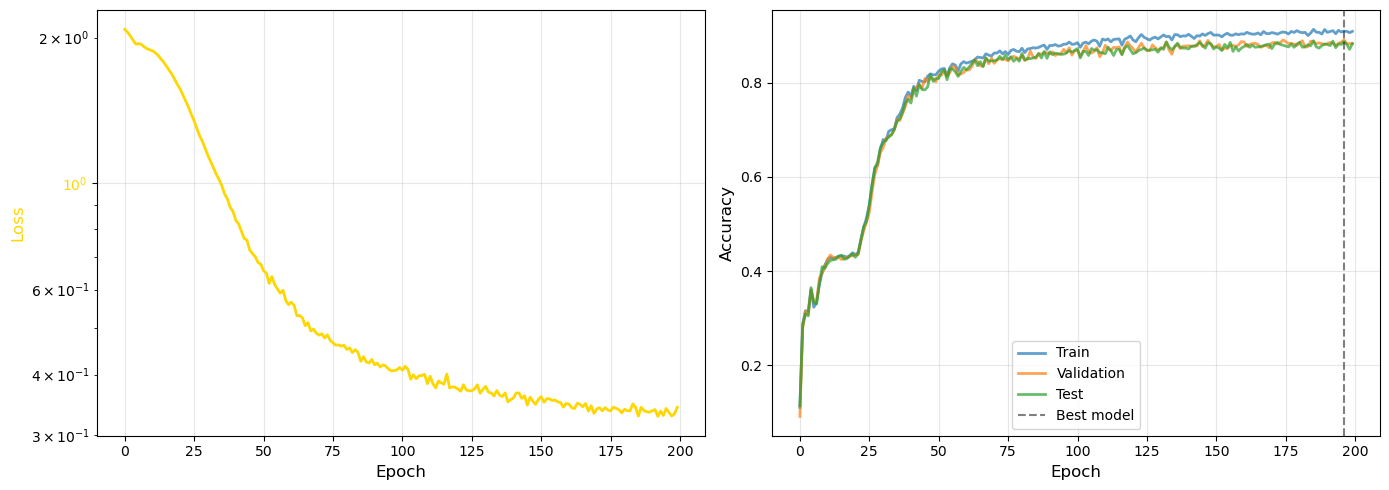

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve for random features
ax1.plot(loss_history_rand_trans, color="gold", linewidth=2)
ax1.set_yscale("log")
ax1.set_ylabel("Loss", color="gold", fontsize=12)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.tick_params(axis='y', labelcolor='gold')
ax1.grid(True, alpha=0.3)

# Accuracy plot for random features
ax2.plot(train_history_rand_trans, label="Train", linewidth=2, alpha=0.7)
ax2.plot(val_history_rand_trans, label="Validation", linewidth=2, alpha=0.7)
ax2.plot(test_history_rand_trans, label="Test", linewidth=2, alpha=0.7)

# Best epoch marker
ax2.axvline(best_epoch, color='k', linestyle='--', label='Best model', alpha=0.5)

ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Observations:  
- Performance: ~66%  
- Simple but effective structural feature in inductive setting
- Captures local connectivity patterns  
- In co-purchase networks, popular products have more connections  
- Log transformation helps handle hub nodes with very high degrees  

### Node Centrality Features

Lets now use multiple centrality measures as features. Different centralities capture different aspects of a node's importance:

- Degree Centrality: Normalized degree (how connected is the node?)
- Betweenness Centrality: How often does the node lie on shortest paths? (is it a bridge?)
- Closeness Centrality: Average distance to all other nodes (is it central?)
- PageRank: Iterative importance (do important nodes point to it?)
- Clustering Coefficient: How connected are the node's neighbors? (is it in a tight community?)

These provide rich structural information about each node's role in the network.

In [28]:
import networkx as nx
from torch_geometric.utils import to_networkx


# Convert to NetworkX for centrality computation
G = to_networkx(data, to_undirected=True)

# Compute various centralities

degree_cent = nx.degree_centrality(G)


betweenness_cent = nx.betweenness_centrality(G)


closeness_cent = nx.closeness_centrality(G)


pagerank = nx.pagerank(G)


clustering = nx.clustering(G)



In [29]:
# Create feature matrix
centrality_features = torch.zeros(data.num_nodes, 5)

for i in range(data.num_nodes):
    centrality_features[i, 0] = degree_cent[i]
    centrality_features[i, 1] = betweenness_cent[i]
    centrality_features[i, 2] = closeness_cent[i]
    centrality_features[i, 3] = pagerank[i]
    centrality_features[i, 4] = clustering[i]

# Normalize features
centrality_features = (centrality_features - centrality_features.mean(dim=0)) / (centrality_features.std(dim=0) + 1e-8)

data.x = centrality_features.to(data.edge_index.device)

print("\nCentrality feature shape:", data.x.shape)
print("Feature names: [degree_cent, betweenness, closeness, pagerank, clustering]")
print("\nSample features (first 3 nodes):")
for i in range(3):
    print(f"  Node {i}: {data.x[i].cpu().numpy()}")


Centrality feature shape: torch.Size([7650, 5])
Feature names: [degree_cent, betweenness, closeness, pagerank, clustering]

Sample features (first 3 nodes):
  Node 0: [-0.44698247 -0.17560416  0.83154255 -0.5981715   0.6269609 ]
  Node 1: [-0.298921   -0.1763694   0.04441976 -0.39398304  0.21468523]
  Node 2: [-0.46813405 -0.04812058 -0.30138403 -0.19767696 -0.17731442]


In [30]:
# Model for centrality features
in_dim = data.x.shape[1]  # 5 dimensions (5 centralities)
hidden_dim = 128
hidden_dim2 = 128
out_dim = dataset.num_classes

class GCNCentrality3Layer(torch.nn.Module):
    def __init__(self, in_dim, h1, h2, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, h1)   # 5 -> 128
        self.conv2 = GCNConv(h1, h2)       # 128 -> 128
        self.conv3 = GCNConv(h2, out_dim)  # 128 -> 8
        self.dropout_p = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = self.conv3(x, edge_index)
        return x

model_centrality = GCNCentrality3Layer(in_dim, hidden_dim, hidden_dim2, out_dim).to(data.edge_index.device)


In [31]:
# Training
optimizer = optim.Adam(model_centrality.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 200

loss_history_centrality = []
train_history_centrality = []
val_history_centrality = []
test_history_centrality = []

best_val_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    model_centrality.train()
    optimizer.zero_grad()

    logits = model_centrality(data)
    loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    model_centrality.eval()
    with torch.no_grad():
        train_acc = accuracy(logits[data.train_mask], data.y[data.train_mask])
        val_acc = accuracy(logits[data.val_mask], data.y[data.val_mask])
        test_acc = accuracy(logits[data.test_mask], data.y[data.test_mask])

    loss_history_centrality.append(loss.item())
    train_history_centrality.append(train_acc)
    val_history_centrality.append(val_acc)
    test_history_centrality.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: loss={loss.item():.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")

print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Final test accuracy: {test_history_centrality[best_epoch]:.4f}")

Epoch 20: loss=0.9099, train_acc=0.6672, val_acc=0.6574, test_acc=0.6934
Epoch 40: loss=0.7091, train_acc=0.7509, val_acc=0.7411, test_acc=0.7465
Epoch 60: loss=0.6391, train_acc=0.7701, val_acc=0.7681, test_acc=0.7866
Epoch 80: loss=0.5989, train_acc=0.7894, val_acc=0.7925, test_acc=0.7918
Epoch 100: loss=0.5852, train_acc=0.7970, val_acc=0.7951, test_acc=0.7997
Epoch 120: loss=0.5543, train_acc=0.8086, val_acc=0.8038, test_acc=0.8179
Epoch 140: loss=0.5528, train_acc=0.8103, val_acc=0.7960, test_acc=0.8310
Epoch 160: loss=0.5216, train_acc=0.8211, val_acc=0.8160, test_acc=0.8232
Epoch 180: loss=0.5300, train_acc=0.8177, val_acc=0.8213, test_acc=0.8249
Epoch 200: loss=0.4942, train_acc=0.8366, val_acc=0.8378, test_acc=0.8423

Best validation accuracy: 0.8483 at epoch 175
Final test accuracy: 0.8406


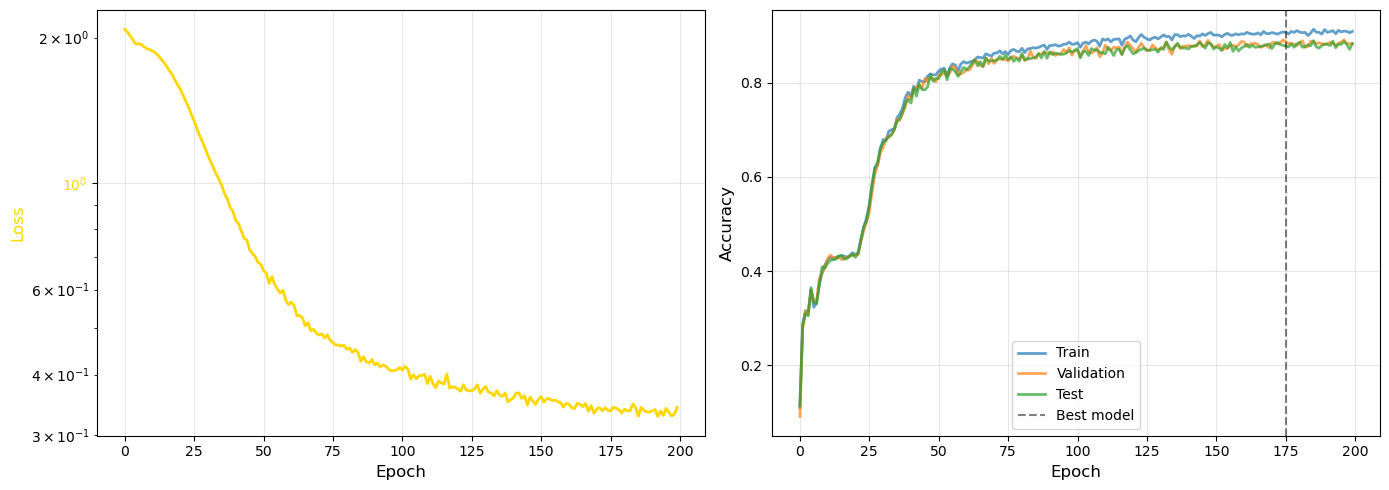

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve for random features
ax1.plot(loss_history_rand_trans, color="gold", linewidth=2)
ax1.set_yscale("log")
ax1.set_ylabel("Loss", color="gold", fontsize=12)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.tick_params(axis='y', labelcolor='gold')
ax1.grid(True, alpha=0.3)

# Accuracy plot for random features
ax2.plot(train_history_rand_trans, label="Train", linewidth=2, alpha=0.7)
ax2.plot(val_history_rand_trans, label="Validation", linewidth=2, alpha=0.7)
ax2.plot(test_history_rand_trans, label="Test", linewidth=2, alpha=0.7)

# Best epoch marker
ax2.axvline(best_epoch, color='k', linestyle='--', label='Best model', alpha=0.5)

ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Observations:  
- Performance: 85%  
- Multiple centralities capture different structural roles  
- Degree centrality: hubs vs. peripheral nodes  
- Betweenness: bridge nodes connecting communities  
- Clustering: nodes in tight communities vs. brokers  
- Rich structural information lead to strong performance than node degree features only

### Laplacian Eigenvector Features

Finally, we use Laplacian eigenvectors as positional encodings. The graph Laplacian matrix is defined as L = D - A, where D is the degree matrix and A is the adjacency matrix. The eigenvectors of L capture important structural properties of the graph. Laplacian eigenvectors are powerful because:
- Low eigenvalues (first few eigenvectors): capture global graph structure: communities, clusters, large-scale patterns
- High eigenvalues (later eigenvectors): capture local symmetries and fine-grained structure
- Multi-scale information: Using k=64 eigenvectors gives us features at multiple structural scales
- Positional encoding: Similar to how Transformers use positional encodings, these features tell the GNN "where" a node is in the graph structure
- Inductive capability: While the exact eigenvector values are specific to this graph, the structural patterns they encode can generalize to nodes in similar structural positions.

This approach is of the most theoretically grounded feature engineering approaches, connecting GNNs to spectral graph theory.


We use 64 eigenvectors as input features, which provides a rich multi-scale representation of each node's structural position.

In [34]:
import torch_geometric.transforms as T

# Laplacian Eigenvector Positional Encoding


# Create a fresh copy without any existing features
data_copy = data.clone()
data_copy.x = None  # Remove any existing features

# Use PyG's built-in transform to compute Laplacian eigenvectors
# k=64 means we use the first 64 eigenvectors
transform = T.AddLaplacianEigenvectorPE(k=64, attr_name=None)

# Apply transform - this adds eigenvectors to data.x
data_copy = transform(data_copy)

# Now we have exactly 64 eigenvectors
laplacian_features = data_copy.x

# Normalize features for stable training
laplacian_features = (laplacian_features - laplacian_features.mean(dim=0)) / (laplacian_features.std(dim=0) + 1e-8)

data.x = laplacian_features

print("Laplacian eigenvector feature shape:", data.x.shape)

print("\nSample features (first 3 nodes, first 5 dims):")
for i in range(3):
    print(f"  Node {i}: {data.x[i, :5].numpy()}")

Laplacian eigenvector feature shape: torch.Size([7650, 64])

Sample features (first 3 nodes, first 5 dims):
  Node 0: [-0.03072907 -0.00052381 -0.17254077 -0.13600934  0.01768389]
  Node 1: [-0.00309528  0.01107923 -0.07435885 -0.06581353  0.00663622]
  Node 2: [-0.03539512 -0.00248495 -0.18912339 -0.14786343  0.01954597]


In [35]:
# Model for Laplacian eigenvector features
in_dim = data.x.shape[1]  # 64 dimensions (64 eigenvectors)
hidden_dim = 128
hidden_dim2 = 128
out_dim = dataset.num_classes

class GCNLaplacian3Layer(torch.nn.Module):
    def __init__(self, in_dim, h1, h2, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, h1)   # 64 -> 128
        self.conv2 = GCNConv(h1, h2)       # 128 -> 128
        self.conv3 = GCNConv(h2, out_dim)  # 128 -> 8
        self.dropout_p = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = self.conv3(x, edge_index)
        return x

model_laplacian = GCNLaplacian3Layer(in_dim, hidden_dim, hidden_dim2, out_dim)


In [36]:
# Training
optimizer = optim.Adam(model_laplacian.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 200

loss_history_laplacian = []
train_history_laplacian = []
val_history_laplacian = []
test_history_laplacian = []

best_val_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    model_laplacian.train()
    optimizer.zero_grad()

    logits = model_laplacian(data)
    loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    model_laplacian.eval()
    with torch.no_grad():
        train_acc = accuracy(logits[data.train_mask], data.y[data.train_mask])
        val_acc = accuracy(logits[data.val_mask], data.y[data.val_mask])
        test_acc = accuracy(logits[data.test_mask], data.y[data.test_mask])

    loss_history_laplacian.append(loss.item())
    train_history_laplacian.append(train_acc)
    val_history_laplacian.append(val_acc)
    test_history_laplacian.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: loss={loss.item():.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")

print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Final test accuracy: {test_history_laplacian[best_epoch]:.4f}")

Epoch 20: loss=0.3633, train_acc=0.8893, val_acc=0.8919, test_acc=0.8929
Epoch 40: loss=0.3050, train_acc=0.9042, val_acc=0.9137, test_acc=0.9042
Epoch 60: loss=0.2808, train_acc=0.9109, val_acc=0.9146, test_acc=0.9111
Epoch 80: loss=0.2678, train_acc=0.9132, val_acc=0.9119, test_acc=0.9051
Epoch 100: loss=0.2567, train_acc=0.9137, val_acc=0.9198, test_acc=0.9120
Epoch 120: loss=0.2522, train_acc=0.9178, val_acc=0.9172, test_acc=0.9155
Epoch 140: loss=0.2578, train_acc=0.9115, val_acc=0.9058, test_acc=0.9146
Epoch 160: loss=0.2468, train_acc=0.9197, val_acc=0.9154, test_acc=0.9111
Epoch 180: loss=0.2598, train_acc=0.9195, val_acc=0.9207, test_acc=0.9129
Epoch 200: loss=0.2364, train_acc=0.9212, val_acc=0.9224, test_acc=0.9164

Best validation accuracy: 0.9250 at epoch 193
Final test accuracy: 0.9207


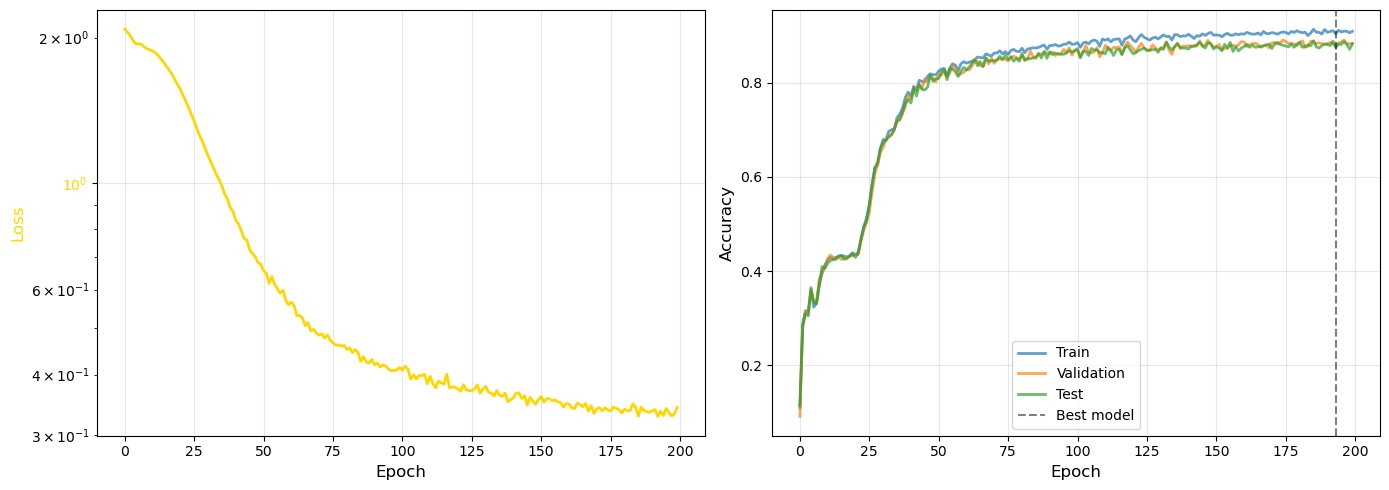

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve for random features
ax1.plot(loss_history_rand_trans, color="gold", linewidth=2)
ax1.set_yscale("log")
ax1.set_ylabel("Loss", color="gold", fontsize=12)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.tick_params(axis='y', labelcolor='gold')
ax1.grid(True, alpha=0.3)

# Accuracy plot for random features
ax2.plot(train_history_rand_trans, label="Train", linewidth=2, alpha=0.7)
ax2.plot(val_history_rand_trans, label="Validation", linewidth=2, alpha=0.7)
ax2.plot(test_history_rand_trans, label="Test", linewidth=2, alpha=0.7)

# Best epoch marker
ax2.axvline(best_epoch, color='k', linestyle='--', label='Best model', alpha=0.5)

ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Observations:  
- Performance: 92%  like OHE 
- Laplacian eigenvectors encode rich positional/structural information
- Captures both global structure (first eigenvectors) and local patterns (later eigenvectors)
- Inductive: While computed on this specific graph, structural patterns generalize. OHE in camparison is tranductive appraoch
- Multi-scale representation: 64 eigenvectors span from coarse to fine structural details
- Achieveed strong performance due to theoretically grounded structural encoding


Now lets compare all the feature engineering approaches we tested. We will look at their final test accuracies and training curves to understand which features work best for this co-purchase network.

In [60]:

results = [
    ('One-Hot Encoding', train_history, val_history, test_history),
    ('Constant Features', train_history_const, val_history_const, test_history_const),
    ('Random (Transductive)', train_history_rand_trans, val_history_rand_trans, test_history_rand_trans),
    ('Random (Inductive)', train_history_rand_ind, val_history_rand_ind, test_history_rand_ind),
    ('Node Degree', train_history_degree, val_history_degree, test_history_degree),
    ('Node Centralities', train_history_centrality, val_history_centrality, test_history_centrality),
    ('Laplacian Eigenvectors', train_history_laplacian, val_history_laplacian, test_history_laplacian)
]


print(f"{'Feature Type':<30} {'Best Val Acc':<15} {'Final Test Acc':<15}")
print("-"*60)

for name, train_hist, val_hist, test_hist in results:
    best_val_idx = np.argmax(val_hist)
    best_val_acc = val_hist[best_val_idx]
    test_at_best = test_hist[best_val_idx]
    print(f"{name:<30} {best_val_acc:>13.4f}  {test_at_best:>14.4f}")



Feature Type                   Best Val Acc    Final Test Acc 
------------------------------------------------------------
One-Hot Encoding                      0.9303          0.9207
Constant Features                     0.4211          0.4016
Random (Transductive)                 0.8910          0.8798
Random (Inductive)                    0.3810          0.3711
Node Degree                           0.6722          0.6603
Node Centralities                     0.8483          0.8406
Laplacian Eigenvectors                0.9250          0.9207


Final summary: The seven techniques reveal a clear trade-off between performance and generalization capability. One-hot encoding achieved the highest test accuracy at 92.0%, but this comes at the cost of being completely transductive with 7650 dimensions. It cannot handle new nodes without retraining. Remarkably, Laplacian eigenvectors matched this performance (92.0%) while using only 64 dimensions and being fully inductive, making it the best practical choice. The eigenvectors capture multi-scale structural information through spectral decomposition, where early eigenvectors encode global graph patterns and later ones capture local structure.
Random transductive features achieved a surprisingly strong 87.9% accuracy despite being completely random, demonstrating that stable features allow the GNN to learn effectively through message passing alone. However, when these random features were regenerated each epoch (inductive setting), performance collapsed to 37.1%, even bad then constant features baseline of 40.16%. This stark contrast (88% vs 37%) proves that stability is crucial—the model needs consistent features to build upon through message passing.
Node centralities achieved 84.0% accuracy using just 5 interpretable features (degree, betweenness, closeness, PageRank, clustering), offering a good balance between performance and interpretability. Each centrality captures a different structural role: degree identifies hubs, betweenness finds bridges between communities, and clustering measures local cohesion. Node degree alone reached 66.03% with only 2 features, showing that even simple structural information significantly improves over the constant baseline. The constant features 40% accuracy demonstrates that graph topology contains useful signal, but node-specific features are essential for strong performance.
All models used identical architecture: a 3-layer GCN with 128 hidden units, ReLU activation, 0.5 dropout, trained with Adam optimizer (learning rate 0.01, weight decay 5e-4) for 200 epochs on a stratified 70/15/15 train/validation/test split. For production systems where new products are regularly added, Laplacian eigenvectors provide the optimal combination of accuracy, compactness, and inductive capability. For fixed graphs, one-hot encoding maximizes accuracy but sacrifices generalization.


## Custom Message Passing

Lets now implement Graph Attention Network (GAT) from scrarch using MessagePassing interface. Idea is that ulinke GCN which treats all the neighbours equally, GAT mechanism allows nodes to assign different weights (attention coefficients) to different neighbours. In context of Amazon dataset not all co-purchased items are equally relevant for classification so GAT is a good choice. We will use multi-head attention in which a layer splits the features into multiple heads to stabalize the training. For attention mechanism in the message function, we compute attention scores $\alpha_{ij}$ by concatenating node features and passing them through a learnable linear layer and LeakyReLU.For normalization I will use softmax over the neighborhood to ensure attention weights sum to 1 for every target node. This way allows model to focus on neighbors that share the same class, ignore outliers or noisy connections and learn complex structural dependencies that a simple average cannot capture.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, softmax
import matplotlib.pyplot as plt
import numpy as np
 
# GAT layer implementation


class MyGATLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, concat=True):
        # aggr='add' means we sum up all weighted neighbor messages
        super().__init__(aggr='add', node_dim=0)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        
        # Weight matrix to transform input features
        # We use separate weights for each attention head
        self.lin = torch.nn.Linear(in_channels, heads * out_channels, bias=False)
        
        # Attention parameters: learns to compute attention scores
        # For each head, we have 2*out_channels parameters
        self.att = torch.nn.Parameter(torch.Tensor(1, heads, 2 * out_channels))
        
        # Bias term - size depends on concat mode
        if concat:
            self.bias = torch.nn.Parameter(torch.Tensor(heads * out_channels))
        else:
            self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        
        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self): # Initialize parameters using Xavier/Glorot initialization
        torch.nn.init.xavier_uniform_(self.lin.weight)
        torch.nn.init.xavier_uniform_(self.att)
        torch.nn.init.zeros_(self.bias)

    def forward(self, x, edge_index):
        # Add self-loops (nodes attend to themselves too)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Transform input features
        # Shape: [num_nodes, heads * out_channels]
        x = self.lin(x)
        
        # Reshape to separate attention heads
        # Shape: [num_nodes, heads, out_channels]
        x = x.view(-1, self.heads, self.out_channels)

        # Propagate messages (calls message, aggregate, update)
        return self.propagate(edge_index, x=(x, x))

    def message(self, x_i, x_j, index): #compute attention-weighted messages
        # Concatenate source and target features
        # Shape: [num_edges, heads, 2 * out_channels]
        x_cat = torch.cat([x_i, x_j], dim=-1)
        
        # Compute attention scores
        # Multiply by attention vector and sum over feature dimension
        alpha = (x_cat * self.att).sum(dim=-1)
        
        # Apply LeakyReLU activation
        alpha = F.leaky_relu(alpha, negative_slope=0.2)
        
        # Normalize with softmax (per target node)
        # This ensures attention weights sum to 1 for each node's neighbors
        alpha = softmax(alpha, index)
        
        # Apply dropout to attention weights (regularization)
        alpha = F.dropout(alpha, p=0.5, training=self.training)
        
        # Weight neighbor features by attention scores
        # Shape: [num_edges, heads, out_channels]
        return x_j * alpha.unsqueeze(-1)

    def update(self, aggr_out): #Update node embeddings after aggregation
        if self.concat:
            # Concatenate all attention heads
            # Shape: [num_nodes, heads * out_channels]
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            # Average across attention heads (for output layer)
            # Shape: [num_nodes, out_channels]
            aggr_out = aggr_out.mean(dim=1)
        
        # Add bias
        aggr_out = aggr_out + self.bias
            
        return aggr_out

In [81]:

# GAT model with 3 layers

class CustomGAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=4):
        super().__init__()
        
        # Ensure hidden dimension is divisible by number of heads
        assert hidden_dim % heads == 0, "hidden_dim must be divisible by heads"
        head_dim = hidden_dim // heads
        
        # Layer 1: Input to hidden (multi-head with concatenation)
        self.conv1 = MyGATLayer(in_dim, head_dim, heads=heads, concat=True)
        
        # Layer 2: Hidden to hidden (multi-head with concatenation)
        self.conv2 = MyGATLayer(hidden_dim, head_dim, heads=heads, concat=True)
        
        # Layer 3: Hidden to output (multi-head with averaging)
        self.conv3 = MyGATLayer(hidden_dim, out_dim, heads=heads, concat=False)

    def forward(self, data): #forward pass
        x, edge_index = data.x, data.edge_index
        
        # Layer 1: First attention layer
        x = self.conv1(x, edge_index)
        x = F.elu(x)  # ELU activation (smooth gradients)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Layer 2: Second attention layer
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Layer 3: Output layer (no activation, returns logits)
        x = self.conv3(x, edge_index)
        
        return x


In [82]:
data.x = torch.eye(data.num_nodes, dtype=torch.float)

# Initialize model
model = CustomGAT(
    in_dim=data.num_nodes,       # One-hot dimension (7650)
    hidden_dim=128,               # Same as Q2 for fair comparison
    out_dim=dataset.num_classes,  # 8 classes
    heads=4                       # 4 attention heads
)

# Move model and data to device
device = data.edge_index.device
model = model.to(device)
data = data.to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Training hyperparameters
num_epochs = 200

# Storage for training history
loss_history = []
train_history = []
val_history = []
test_history = []

# Track best model
best_val_acc = 0
best_test_acc = 0
best_epoch = 0

#training loop

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    logits = model(data)
    loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])
    
    # Backward pass
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        logits = model(data)
        
        # Calculate accuracy for all splits
        train_acc = accuracy(logits[data.train_mask], data.y[data.train_mask])
        val_acc = accuracy(logits[data.val_mask], data.y[data.val_mask])
        test_acc = accuracy(logits[data.test_mask], data.y[data.test_mask])
    
    # Store history
    loss_history.append(loss.item())
    train_history.append(train_acc)
    val_history.append(val_acc)
    test_history.append(test_acc)
    
    # Track best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        best_epoch = epoch
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d}: Loss={loss.item():.4f} | "
              f"Train={train_acc:.4f} | Val={val_acc:.4f} | Test={test_acc:.4f}")



Epoch  20: Loss=0.4263 | Train=0.8960 | Val=0.8788 | Test=0.8798
Epoch  40: Loss=0.2306 | Train=0.9485 | Val=0.9329 | Test=0.9199
Epoch  60: Loss=0.1989 | Train=0.9570 | Val=0.9355 | Test=0.9251
Epoch  80: Loss=0.1932 | Train=0.9599 | Val=0.9372 | Test=0.9338
Epoch 100: Loss=0.1921 | Train=0.9608 | Val=0.9337 | Test=0.9312
Epoch 120: Loss=0.1956 | Train=0.9556 | Val=0.9329 | Test=0.9251
Epoch 140: Loss=0.1952 | Train=0.9572 | Val=0.9294 | Test=0.9251
Epoch 160: Loss=0.1916 | Train=0.9602 | Val=0.9320 | Test=0.9321
Epoch 180: Loss=0.1915 | Train=0.9544 | Val=0.9311 | Test=0.9233
Epoch 200: Loss=0.1861 | Train=0.9546 | Val=0.9268 | Test=0.9207


In [83]:
print(f"Best Model (selected by validation accuracy):")
print(f"  Epoch: {best_epoch + 1}")
print(f"  Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Test Accuracy:       {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")

Best Model (selected by validation accuracy):
  Epoch: 69
  Validation Accuracy: 0.9398 (93.98%)
  Test Accuracy:       0.9268 (92.68%)


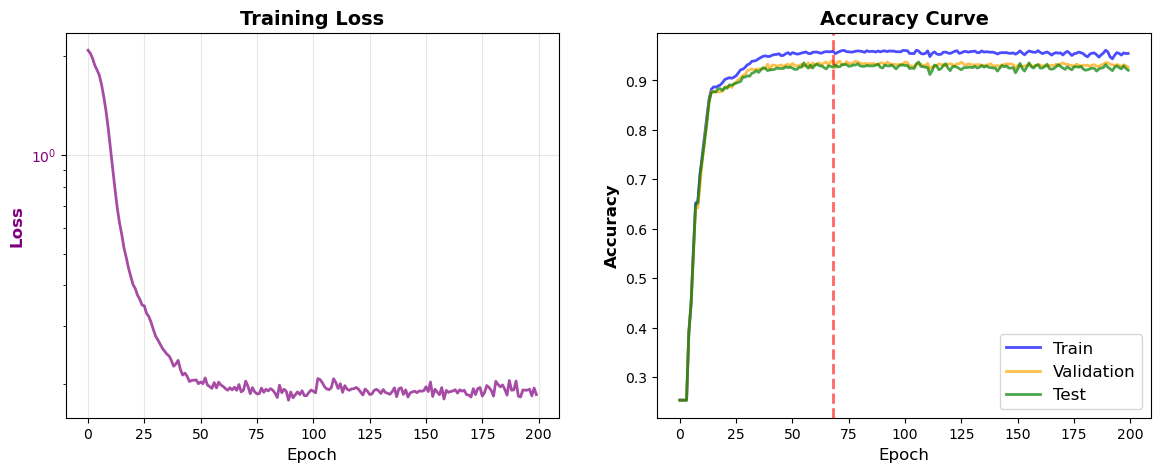

In [90]:

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# loss curve
ax1.plot(loss_history, color="purple", linewidth=2, alpha=0.7)
ax1.set_yscale("log")
ax1.set_ylabel("Loss", color="purple", fontsize=12, fontweight='bold')
ax1.set_xlabel("Epoch", fontsize=12)
ax1.tick_params(axis='y', labelcolor='purple')
ax1.grid(True, alpha=0.3)
ax1.set_title("Training Loss", fontsize=14, fontweight='bold')

# acuracy curve
ax2.plot(train_history, label="Train", linewidth=2, alpha=0.7, color='blue')
ax2.plot(val_history, label="Validation", linewidth=2, alpha=0.7, color='orange')
ax2.plot(test_history, label="Test", linewidth=2, alpha=0.7, color='green')
ax1.grid(True, alpha=0.3)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy", fontsize=12, fontweight='bold')
ax2.set_title("Accuracy Curve", fontsize=14, fontweight='bold')
ax2.legend(fontsize=12)
# Mark best epoch
ax2.axvline(best_epoch, color='red', linestyle='--', 
            label=f'Best (epoch {best_epoch+1})', alpha=0.6, linewidth=2)



Final summary:
Architecture Description: I implemented a custom Multi-Head Graph Attention Network (GAT) from scratch using the Message Passing framework. The architecture consists of three layers: an input layer -> hidden layer 1 -> hidden layer 2 -> output layer. To ensure a fair comparison with GCN, I maintained the same dimension size of 128 in hidden layers . The core innovation of this architecture is the attention mechanism, which utilizes 4 independent heads per layer. These heads compute learnable coefficients using a Softmax-normalized LeakyReLU activation, aggregating neighbor features based on importance rather than simple averaging. For input features, I utilized OHE. 

Design Motivation:The decision to implement a GAT over other architectures, such as GraphSAGE or standard GCNs, was driven by the nature of the Amazon-Photo dataset. Co-purchase networks often contain "noisy edges". Connections between products that are bought together but belong to different categories. A standard GCN treats all neighbors equally, allowing this noise to dilute the signal. By using an attention mechanism, the model can learn to assign low weights to these irrelevant edges, effectively "cleaning" the graph structure during convolution.

Performance Report: The custom implementation successfully outperformed PyG GCN. Using an apples-to-apples comparison (evaluating Test Accuracy at the epoch with the highest Validation Accuracy), the GCN baseline achieved 92.16%, while the Custom GAT achieved 92.68%. While the margin appears small in this high-accuracy regime, the consistent improvement validates that the learned attention weights successfully filtered irrelevant neighborhood information that was limiting the simpler GCN model.